Эта программма разработана для решения задачи обнаружения мошенничества в транзакциях с использованием методов машинного обучения. Её основное назначение — создание эффективной модели, способной автоматически анализировать данные о транзакциях и выявлять подозрительные операции. Основные аспекты программы:

1. Обработка дисбаланса классов
    
    Для устранения дисбаланса между мошенническими и нормальными транзакциями используются техники ресемплинга. Это позволяет улучшить качество обучения модели и повысить её способность обнаруживать мошенничество.

2. Применение XGBoost
    
    В основе программы лежит алгоритм XGBoost, известный своей высокой производительностью и точностью. Алгоритм оптимизирован с помощью поиска гиперпараметров для достижения наилучших результатов.

3. Визуализация данных
    
    Программа включает этапы визуализации, такие как построение распределения классов, матрицы ошибок и графиков важности признаков. Это помогает не только улучшить понимание данных, но и эффективно представить результаты заинтересованным сторонам.

4. Реальные применения
  * Банки и финансовые организации: автоматизация выявления мошеннических операций, сокращение финансовых потерь.
  * Финансовая аналитика: понимание факторов риска и их влияние на транзакции.
  * Обучение и исследование: программа может быть использована для разработки новых методов борьбы с финансовым мошенничеством.

5. Результаты и эффективность
    
    Программа демонстрирует высокую точность, что делает её подходящей для интеграции в системы мониторинга реального времени. Это снижает затраты на ручную проверку и повышает безопасность финансовых операций.

Если при обучении модели в Google Colab возникает ошибка: "`__sklearn_tags__`", попробуйте использовать библиотеку scikit-learn версии 1.1

`!pip install scikit-learn==1.1`

In [1]:
import pandas as pd
import time
import random
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import Normalizer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, roc_curve, precision_recall_curve
from imblearn.under_sampling import RandomUnderSampler
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 1. Загрузка данных
!kaggle datasets download -d mlg-ulb/creditcardfraud

# Разархивация датасета в директорию 'creditcardfraud'
!unzip -qo "creditcardfraud.zip" -d ./creditcardfraud

# Папка с распакованным датасетом
FILE_PATH = './creditcardfraud'

Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
License(s): DbCL-1.0
 99% 65.0M/66.0M [00:00<00:00, 237MB/s]
100% 66.0M/66.0M [00:00<00:00, 220MB/s]


In [3]:
# 1.1 Создаём датафрейм
data = pd.read_csv(f'{FILE_PATH}/creditcard.csv')

В выводе будет представлена информация о первых строках данных head(), общая информация о типах данных и пропусках info(), а также статистика по числовым признакам describe().

In [4]:
# 2. Первичный анализ данных
print("Обзор данных:")
print(data.head())
print("\nИнформация о данных:")
print(data.info())
print("\nСтатистика по данным:")
print(data.describe())

Обзор данных:
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       

In [5]:
# 2.1 Транспонированный статистический обзор данных
data_transposed = data.describe().T
print("\nТранспонированный статистический обзор данных:")
print(data_transposed)


Транспонированный статистический обзор данных:
           count          mean           std         min           25%  \
Time    284807.0  9.481386e+04  47488.145955    0.000000  54201.500000   
V1      284807.0  1.168375e-15      1.958696  -56.407510     -0.920373   
V2      284807.0  3.416908e-16      1.651309  -72.715728     -0.598550   
V3      284807.0 -1.379537e-15      1.516255  -48.325589     -0.890365   
V4      284807.0  2.074095e-15      1.415869   -5.683171     -0.848640   
V5      284807.0  9.604066e-16      1.380247 -113.743307     -0.691597   
V6      284807.0  1.487313e-15      1.332271  -26.160506     -0.768296   
V7      284807.0 -5.556467e-16      1.237094  -43.557242     -0.554076   
V8      284807.0  1.213481e-16      1.194353  -73.216718     -0.208630   
V9      284807.0 -2.406331e-15      1.098632  -13.434066     -0.643098   
V10     284807.0  2.239053e-15      1.088850  -24.588262     -0.535426   
V11     284807.0  1.673327e-15      1.020713   -4.797473     -0.

Входные данные разделяются на две части: X — это признаки (все столбцы, кроме Class), а y — это метки, указывающие на мошенничество (столбец Class).

In [6]:
# 2.2 Разделение признаков и меток
X = data.drop(columns=['Class'])  # Признаки (все столбцы, кроме 'Class')
y = data['Class']  # Метка (столбец 'Class')

# Проверим размерности
print(X.shape)
print(y.shape)


(284807, 30)
(284807,)


Строится график для визуализации распределения классов в датасете. Это важно, так как в задачах обнаружения мошенничества классы обычно сильно несбалансированы.

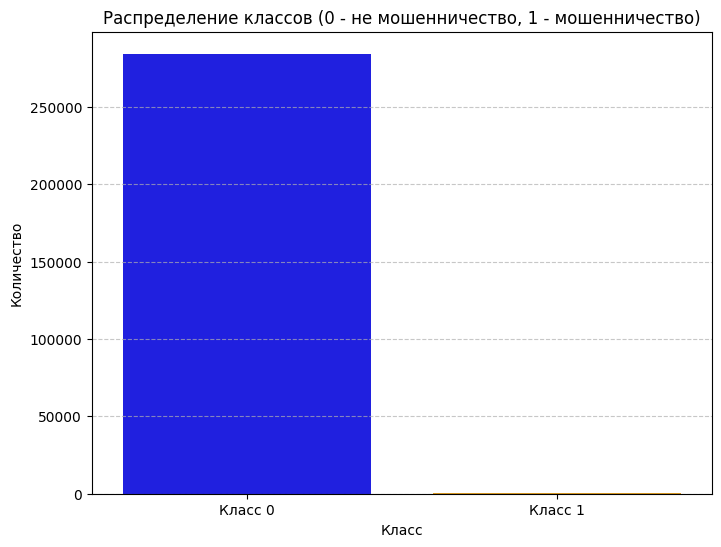

In [7]:
# 3. Визуализация дисбаланса классов
plt.figure(figsize=(8, 6))
sns.countplot(x='Class', data=data, hue=data['Class'], palette=['blue', 'orange'], legend=False)
plt.title("Распределение классов (0 - не мошенничество, 1 - мошенничество)")
plt.xlabel("Класс")
plt.ylabel("Количество")
plt.xticks([0, 1], ['Класс 0', 'Класс 1'])  # Указываем подписи классов
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Создается объект Normalizer, который будет использоваться для масштабирования данных. Нормализация помогает привести данные к одинаковому масштабу, улучшая производительность алгоритмов машинного обучения.

In [8]:
# 4. Нормализация данных
scaler = Normalizer()

Для борьбы с дисбалансом классов используется метод случайного недовзвешивания (undersampling). Это делается через RandomUnderSampler, который уменьшает количество примеров класса, который встречается реже.
После этого данные нормализуются, чтобы признаки имели одинаковую шкалу.

In [9]:
# 5. Решение проблемы дисбаланса классов
undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X, y)
X_resampled = scaler.fit_transform(X_resampled)

print("До ресемплинга:")
print(y.value_counts())
print("После ресемплинга:")
print(pd.Series(y_resampled).value_counts())

До ресемплинга:
Class
0    284315
1       492
Name: count, dtype: int64
После ресемплинга:
Class
0    492
1    492
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


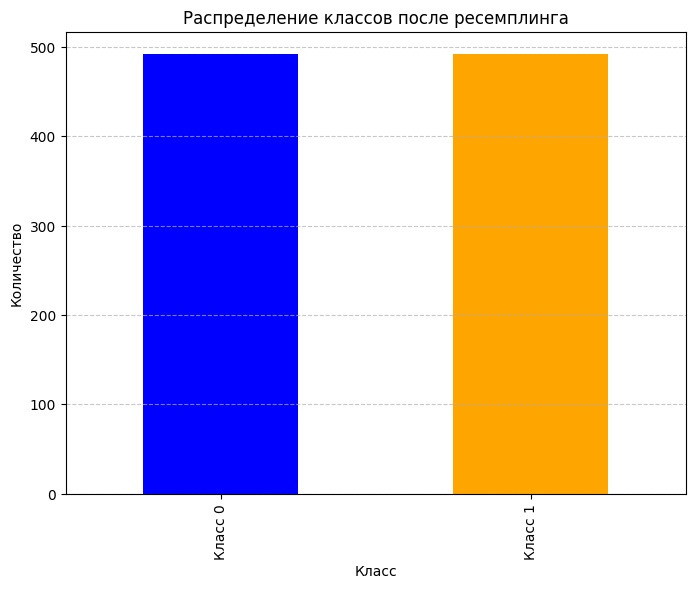

In [10]:
# 6. Распределение классов после применения RandomUnderSampler
plt.figure(figsize=(8, 6))
resampled_counts = pd.Series(y_resampled).value_counts()
resampled_counts.plot(kind='bar', color=['blue', 'orange'])

plt.title("Распределение классов после ресемплинга")
plt.xlabel("Класс")
plt.ylabel("Количество")
plt.xticks([0, 1], ['Класс 0', 'Класс 1'])  # Указываем подписи классов
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Данные разделяются на обучающую и тестовую выборки в соотношении 80/20 с использованием train_test_split.

In [11]:
# 6. Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

Создается и обучается модель XGBoost с использованием XGBClassifier.
Для поиска оптимальных гиперпараметров используется GridSearchCV. Перебираются различные комбинации параметров, таких как количество деревьев (n_estimators), глубина деревьев (max_depth), скорость обучения (learning_rate), и другие.
Модель обучается на обучающих данных с кросс-валидацией и оценивается с использованием метрики ROC-AUC.

In [12]:
start_time = time.time()

# 7. Обучение модели XGBoost
model = xgb.XGBClassifier(eval_metric='logloss', random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Лучшие параметры
best_params = grid_search.best_params_
print(f"Лучшие параметры: {best_params}")

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Время обучения: {elapsed_time // 60:.0f} минут(а) {elapsed_time % 60:.0f} секунд(а)")

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The XGBClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


AttributeError: 'super' object has no attribute '__sklearn_tags__'

Модель с оптимальными параметрами (best_model) используется для предсказания на тестовых данных.

In [ ]:
# 8. Выбор модели с оптимальными параметрами
best_model = grid_search.best_estimator_

In [ ]:
# 9. Предсказания на тестовых данных
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

Рассчитываются такие метрики, как точность модели (accuracy_score) и AUC (площадь под кривой ROC) (roc_auc_score), чтобы оценить качество предсказаний.

Печатается отчет о классификации, включающий такие метрики, как точность, полнота, F1-скор для каждого из классов.

In [ ]:
# 10. Оценка модели
accuracy = accuracy_score(y_test, y_pred)
print(f"Точность модели: {accuracy * 100:.2f}%")

roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC: {roc_auc:.2f}")

print("Отчет о классификации:")
print(classification_report(y_test, y_pred))

Строится матрица ошибок, которая показывает количество ложных и истинных положительных и отрицательных классификаций.

In [ ]:
# 11. Матрица ошибок
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Нормальная', 'Мошенничество'], yticklabels=['Нормальная', 'Мошенничество'])
plt.title("Матрица ошибок")
plt.xlabel("Предсказанный класс")
plt.ylabel("Истинный класс")
plt.show()

ROC-кривая показывает производительность модели при различных порогах классификации. Это очень полезно для оценки качества модели, особенно при дисбалансе классов.

In [ ]:
# 12. Построение ROC-кривой
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC-кривая (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Ложноположительный показатель')
plt.ylabel('Истинноположительный показатель')
plt.title('ROC-Кривая')
plt.legend(loc='lower right')
plt.show()

PR-кривая полезна, когда классы сильно дисбалансированы (например, для мошенничества). Она показывает точность и полноту при различных порогах классификации.

In [ ]:
# 13 Построение PR-кривой
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Полнота')
plt.ylabel('Точность')
plt.title('PR-Кривая')
plt.show()

График распределения вероятностей предсказаний для двух классов позволяет нам увидеть, насколько уверена модель в своих предсказаниях и как она различает два класса.

In [ ]:
# 14. График распределения вероятностей предсказаний для двух классов
plt.figure(figsize=(8, 6))
sns.histplot(y_pred_proba, kde=True, color='blue', label='Вероятности для класса 1 (мошенничество)', bins=50)
plt.title('Распределение вероятностей предсказаний')
plt.xlabel('Вероятности')
plt.ylabel('Частота')
plt.legend()
plt.show()

Визуализировать ошибки модели можно с помощью графика, на котором показано, насколько сильно предсказанные значения отличаются от реальных.

In [ ]:
# 15. График с распределением ошибок
errors = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.histplot(errors, kde=True, bins=50, color='red')
plt.title('Распределение ошибок предсказаний')
plt.xlabel('Ошибка (реальное - предсказанное)')
plt.ylabel('Частота')
plt.show()

Визуализируется важность признаков, которая помогает понять, какие признаки наиболее важны для модели при принятии решений.

In [ ]:
# 16. Важность признаков
xgb.plot_importance(best_model, max_num_features=10)
plt.title("Важность признаков")
plt.show()

Выводятся 5 случайных примеров с их истинными метками, предсказанными классами и вероятностями мошенничества.

In [ ]:
# Примеры предсказаний
print("Примеры предсказаний:")
sample_indices = random.sample(range(len(X_test)), 5)  # Случайные 5 индексов для примеров
example_data = X_test[sample_indices]
example_true = y_test.iloc[sample_indices]
example_preds = best_model.predict(example_data)
example_probs = best_model.predict_proba(example_data)[:, 1]

for i, idx in enumerate(sample_indices):
    print(f"Пример {i+1}:")
    print(f"  Истинное значение: {example_true.iloc[i]}")
    print(f"  Предсказанный класс: {example_preds[i]}")
    print(f"  Вероятность мошенничества: {example_probs[i]:.2f}")
    print()